In [2]:
%cd /content/drive/MyDrive/MLCB/Project/Data

/content/drive/MyDrive/MLCB/Project/Data


In [41]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import json
import networkx as nx
import numpy as np
import pickle

,index,id1,name1,id2,name2,interaction
0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects can be...
1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration of Abemaciclib can be ...
2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration of Abemaciclib can be ...
3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism of Abemaciclib can be decreased...
4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism of Abemaciclib can be decreased...


In [46]:
import json
import numpy as np

def load_drug_features(filename="drug_features_n.pkl"):
    with open(filename, 'rb') as f:
        drug_features = pickle.load(f)
    return drug_features


In [49]:
drug_features = load_drug_features("drug_features_n.pkl")

In [51]:
len(drug_features.keys())

572

In [50]:
import torch

class SimilarityComputer:
    def __init__(self, drug_features, c=1.0):
        self.drug_features = drug_features
        self.c = c
        self.drug_ids = list(drug_features.keys())
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def gaussian_similarity(self, vec_a, vec_b):
        """Compute Gaussian kernel similarity between two vectors (on GPU)."""
        vec_a = torch.tensor(vec_a, dtype=torch.float32, device=self.device)
        vec_b = torch.tensor(vec_b, dtype=torch.float32, device=self.device)

        distance = torch.norm(vec_a - vec_b)
        sim = torch.exp(-self.c * distance**2)
        return sim.item()  # Return as Python float

    def compute_similarity_matrix(self, feature_type):
        """Compute full similarity matrix for given feature type."""
        n = len(self.drug_ids)
        sim_matrix = torch.zeros((n, n), device=self.device)

        for i in range(n):
            for j in range(i, n):
                vec_i = self.drug_features[self.drug_ids[i]][feature_type]
                vec_j = self.drug_features[self.drug_ids[j]][feature_type]
                sim = self.gaussian_similarity(vec_i, vec_j)

                sim_matrix[i, j] = sim
                sim_matrix[j, i] = sim  # Symmetric

        return sim_matrix.cpu().numpy()  # Return as numpy array for easier graph building


In [52]:


def build_graph_from_similarity(sim_matrix, drug_ids, threshold=0.0):
    """Build a weighted undirected graph from a similarity matrix."""
    G = nx.Graph()

    n = len(drug_ids)
    for i in range(n):
        G.add_node(drug_ids[i])

    for i in range(n):
        for j in range(i+1, n):
            weight = sim_matrix[i, j]
            if weight > threshold:
                G.add_edge(drug_ids[i], drug_ids[j], weight=weight)

    return G


In [53]:
similarity_computer = SimilarityComputer(drug_features, c=1.0)

# Step 3: Compute similarity matrices
target_sim_matrix = similarity_computer.compute_similarity_matrix('target')
enzyme_sim_matrix = similarity_computer.compute_similarity_matrix('enzyme')
smiles_sim_matrix = similarity_computer.compute_similarity_matrix('smiles')

# Step 4: Build graphs
drug_ids = list(drug_features.keys())

target_graph = build_graph_from_similarity(target_sim_matrix, drug_ids, threshold=0.0)
enzyme_graph = build_graph_from_similarity(enzyme_sim_matrix, drug_ids, threshold=0.0)
smiles_graph = build_graph_from_similarity(smiles_sim_matrix, drug_ids, threshold=0.0)

In [54]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(G, title="Graph", max_nodes=50):
    """Visualize the graph using a spring layout."""
    plt.figure(figsize=(10, 8))

    # If too many nodes, take a subgraph
    if len(G.nodes) > max_nodes:
        nodes = list(G.nodes)[:max_nodes]
        G = G.subgraph(nodes)

    pos = nx.spring_layout(G, seed=42)  # spring layout for better clustering
    weights = [G[u][v]['weight'] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
    nx.draw_networkx_edges(G, pos, width=[w * 3 for w in weights], alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title(title)
    plt.axis('off')
    plt.show()


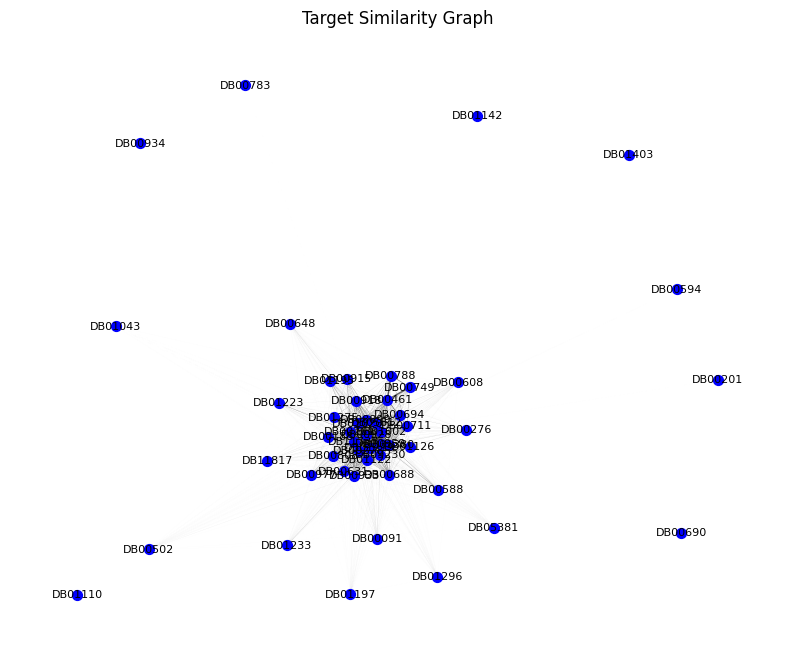

In [55]:
visualize_graph(target_graph, title="Target Similarity Graph")



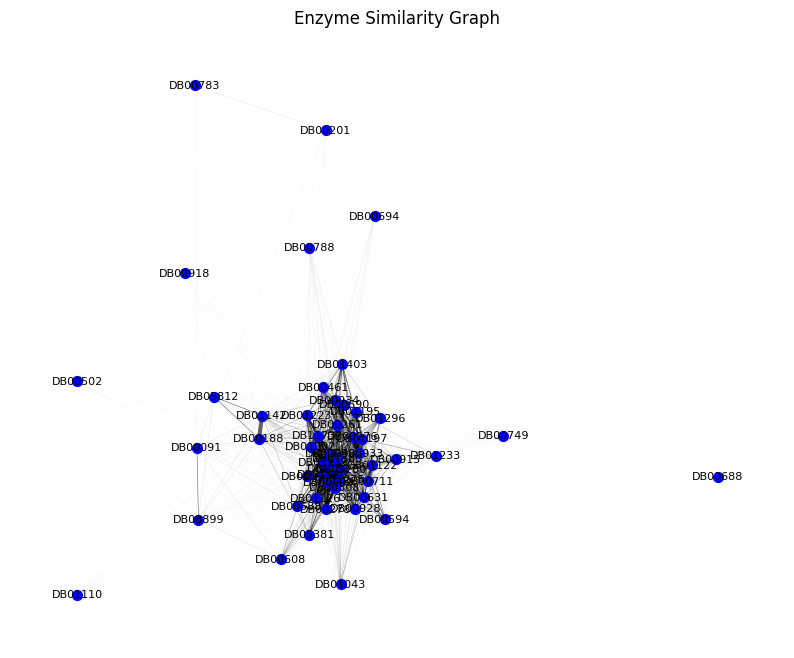

In [56]:
visualize_graph(enzyme_graph, title="Enzyme Similarity Graph")


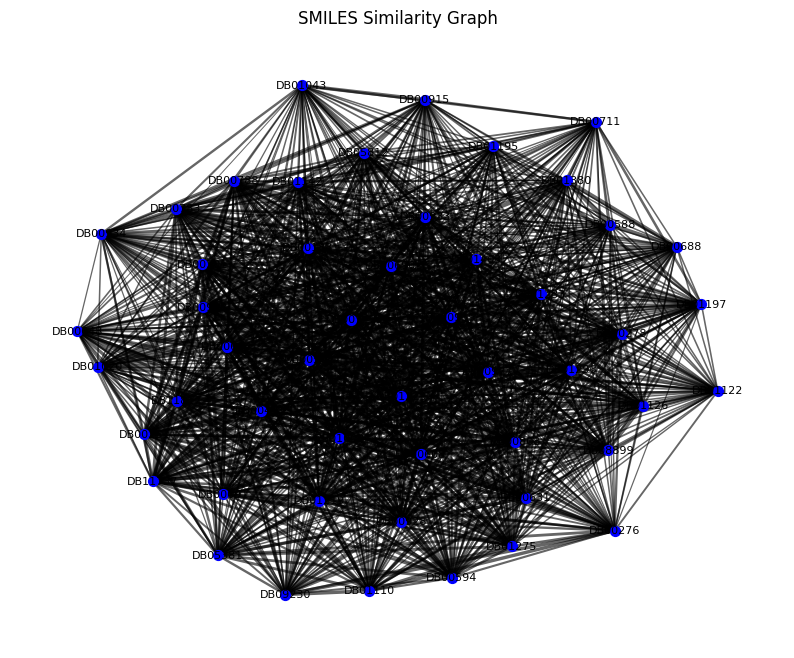

In [57]:
visualize_graph(smiles_graph, title="SMILES Similarity Graph")

USING GraphSeq model to find neighbours and stack their simu=ilarities


In [61]:
import numpy as np

class Graph2Seq:
    def __init__(self, target_graph, enzyme_graph, smiles_graph, drug_ids):
        self.target_graph = target_graph
        self.enzyme_graph = enzyme_graph
        self.smiles_graph = smiles_graph
        self.drug_ids = drug_ids

    def _get_graph_features(self, graph, drug_id):
        """Return a fixed-size vector of neighbor edge weights."""
        neighbors = list(graph.neighbors(drug_id))
        features = []
        for neighbor in self.drug_ids:  # ensure consistent order
            if neighbor in neighbors:
                weight = graph[drug_id][neighbor]['weight']
                features.append(weight)
            else:
                features.append(0.0)
        return features

    def build_sequences(self):
        """Build final Graph2Seq features for all drugs."""
        graph2seq_features = {}

        for drug_id in self.drug_ids:
            target_feats = self._get_graph_features(self.target_graph, drug_id)
            enzyme_feats = self._get_graph_features(self.enzyme_graph, drug_id)
            smiles_feats = self._get_graph_features(self.smiles_graph, drug_id)

            # Concatenate: [target features | enzyme features | smiles features]
            full_feature = np.concatenate([target_feats, enzyme_feats, smiles_feats])
            graph2seq_features[drug_id] = full_feature

        return graph2seq_features


In [62]:
graph2seq_builder = Graph2Seq(
    target_graph=target_graph,
    enzyme_graph=enzyme_graph,
    smiles_graph=smiles_graph,
    drug_ids=drug_ids
)

# 2. Build the sequences
graph2seq_features = graph2seq_builder.build_sequences()

Final vector for each drug is a 572*3, where ech 572 has the similarity weight of its neighbour

In [63]:


def save_graph2seq_features(features, filepath):
    """Save graph2seq features dictionary to a file."""
    with open(filepath, 'wb') as f:
        pickle.dump(features, f)
save_graph2seq_features(graph2seq_features, "graph2seq_features.pkl")

In [64]:
def load_graph2seq_features(filepath):
    """Load graph2seq features dictionary from a file."""
    with open(filepath, 'rb') as f:
        features = pickle.load(f)
    return features

In [31]:
graph2seq_features["DB01296"]

array([0.00000000e+00, 2.47875089e-03, 2.47875089e-03, ...,
       3.10144295e-28, 1.18485999e-22, 5.72828236e-28])

In [65]:
graph2seq_features = load_graph2seq_features("graph2seq_features.pkl")

In [36]:
events = pd.read_csv("event.csv")
events.head(5)

,index,id1,name1,id2,name2,interaction
0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects can be...
1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration of Abemaciclib can be ...
2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration of Abemaciclib can be ...
3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism of Abemaciclib can be decreased...
4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism of Abemaciclib can be decreased...


EXTRA DATA MAnipulation

In [ ]:
# extract = pd.read_csv("extraction.csv")
# extract.head(5)

,index,mechanism,action,drugA,drugB
0,0,The risk or severity of adverse effects,increase,Abemaciclib,Amiodarone
1,1,The serum concentration,decrease,Abemaciclib,Apalutamide
2,2,The serum concentration,increase,Abemaciclib,Aprepitant
3,3,The metabolism,decrease,Abemaciclib,Atomoxetine
4,4,The metabolism,decrease,Abemaciclib,Bortezomib


In [ ]:
# import pandas as pd

# def join_events_with_mechanism(events_df, mech_action_df):
#     """
#     Join the events file with mechanism/action file based on drug names.
#     """
#     # Rename columns for clean merging
#     mech_action_df = mech_action_df.rename(columns={"drugA": "name1", "drugB": "name2"})

#     # Merge on name1 and name2
#     merged_df = events_df.merge(mech_action_df[['name1', 'name2', 'mechanism', 'action']],
#                                 on=['name1', 'name2'],
#                                 how='left')

#     return merged_df


In [ ]:


# merged_df = join_events_with_mechanism(events, extract)



In [ ]:
# merged_df

,index,id1,name1,id2,name2,interaction,mechanism,action
0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects can be...,The risk or severity of adverse effects,increase
1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration of Abemaciclib can be ...,The serum concentration,decrease
2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration of Abemaciclib can be ...,The serum concentration,increase
3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism of Abemaciclib can be decreased...,The metabolism,decrease
4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism of Abemaciclib can be decreased...,The metabolism,decrease
...,...,...,...,...,...,...,...,...
37259,37259,DB01149,Nefazodone,DB09048,Netupitant,The serum concentration of Nefazodone can be i...,The serum concentration,increase
37260,37260,DB01149,Nefazodone,DB00622,Nicardipine,The metabolism of Nefazodone can be decreased ...,The metabolism,decrease
37261,37261,DB11828,Neratinib,DB09048,Netupitant,The serum concentration of Neratinib can be in...,The serum concentration,increase
37262,37262,DB09048,Netupitant,DB00622,Nicardipine,The serum concentration of Netupitant can be i...,The serum concentration,increase


In [ ]:
# merged_df.to_csv("events_extract.csv")

In [ ]:


# def assign_labels_to_interactions(ddi_df):
#     """Create mapping from interaction text to numeric labels and assign labels."""

#     # Step 1: Get all unique interactions
#     unique_interactions = ddi_df['mechanism'].unique()

#     # Step 2: Create interaction → label mapping
#     interaction_to_label = {interaction: idx for idx, interaction in enumerate(unique_interactions)}

#     # Step 3: Assign numeric labels
#     ddi_df['label'] = ddi_df['mechanism'].map(interaction_to_label)

#     return ddi_df, interaction_to_label

In [ ]:
# events = pd.read_csv("events_extract.csv")
# events, labels = assign_labels_to_interactions(events)
# events

,Unnamed: 0,index,id1,name1,id2,name2,interaction,mechanism,action,label
0,0,0,DB12001,Abemaciclib,DB01118,Amiodarone,The risk or severity of adverse effects can be...,The risk or severity of adverse effects,increase,0
1,1,1,DB12001,Abemaciclib,DB11901,Apalutamide,The serum concentration of Abemaciclib can be ...,The serum concentration,decrease,1
2,2,2,DB12001,Abemaciclib,DB00673,Aprepitant,The serum concentration of Abemaciclib can be ...,The serum concentration,increase,1
3,3,3,DB12001,Abemaciclib,DB00289,Atomoxetine,The metabolism of Abemaciclib can be decreased...,The metabolism,decrease,2
4,4,4,DB12001,Abemaciclib,DB00188,Bortezomib,The metabolism of Abemaciclib can be decreased...,The metabolism,decrease,2
...,...,...,...,...,...,...,...,...,...,...
37259,37259,37259,DB01149,Nefazodone,DB09048,Netupitant,The serum concentration of Nefazodone can be i...,The serum concentration,increase,1
37260,37260,37260,DB01149,Nefazodone,DB00622,Nicardipine,The metabolism of Nefazodone can be decreased ...,The metabolism,decrease,2
37261,37261,37261,DB11828,Neratinib,DB09048,Netupitant,The serum concentration of Neratinib can be in...,The serum concentration,increase,1
37262,37262,37262,DB09048,Netupitant,DB00622,Nicardipine,The serum concentration of Netupitant can be i...,The serum concentration,increase,1


In [ ]:
# len(events['label'].unique())

56

In [ ]:
# events.to_csv("events_extract.csv")

In [66]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)

        # Mean and log variance for latent space
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Optional Decoder (if you want reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, logvar


In [67]:
def vae_loss(reconstructed_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(reconstructed_x, x)  # could also use BCE
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [68]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# 1. Dataset for Graph2Seq features
class Graph2SeqFeatureDataset(Dataset):
    def __init__(self, graph2seq_features):
        self.features = list(graph2seq_features.values())

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32)

# 2. Loss function for VAE
def vae_loss(reconstructed_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(reconstructed_x, x)  # Reconstruction loss
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence loss
    return recon_loss + kl_loss

# 3. Full training function
def train_vae(model, dataloader, optimizer, device, epochs=100):
    model = model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            batch = batch.to(device)

            optimizer.zero_grad()
            reconstructed_batch, mu, logvar = model(batch)
            loss = vae_loss(reconstructed_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} | VAE Loss: {avg_loss:.4f}")

    return model


In [69]:
# Suppose you already have graph2seq_features
input_dim = next(iter(graph2seq_features.values())).shape[0]

vae = VAE(input_dim=input_dim, latent_dim=64)

vae_dataset = Graph2SeqFeatureDataset(graph2seq_features)
vae_loader = DataLoader(vae_dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Train the VAE
trained_vae = train_vae(vae, vae_loader, optimizer, device, epochs=50)


Epoch 1/50 | VAE Loss: 0.0519
Epoch 2/50 | VAE Loss: 0.0190
Epoch 3/50 | VAE Loss: 0.0157
Epoch 4/50 | VAE Loss: 0.0152
Epoch 5/50 | VAE Loss: 0.0144
Epoch 6/50 | VAE Loss: 0.0143
Epoch 7/50 | VAE Loss: 0.0139
Epoch 8/50 | VAE Loss: 0.0138
Epoch 9/50 | VAE Loss: 0.0135
Epoch 10/50 | VAE Loss: 0.0136
Epoch 11/50 | VAE Loss: 0.0132
Epoch 12/50 | VAE Loss: 0.0132
Epoch 13/50 | VAE Loss: 0.0132
Epoch 14/50 | VAE Loss: 0.0131
Epoch 15/50 | VAE Loss: 0.0130
Epoch 16/50 | VAE Loss: 0.0129
Epoch 17/50 | VAE Loss: 0.0130
Epoch 18/50 | VAE Loss: 0.0129
Epoch 19/50 | VAE Loss: 0.0130
Epoch 20/50 | VAE Loss: 0.0129
Epoch 21/50 | VAE Loss: 0.0128
Epoch 22/50 | VAE Loss: 0.0127
Epoch 23/50 | VAE Loss: 0.0125
Epoch 24/50 | VAE Loss: 0.0128
Epoch 25/50 | VAE Loss: 0.0126
Epoch 26/50 | VAE Loss: 0.0126
Epoch 27/50 | VAE Loss: 0.0126
Epoch 28/50 | VAE Loss: 0.0125
Epoch 29/50 | VAE Loss: 0.0125
Epoch 30/50 | VAE Loss: 0.0127
Epoch 31/50 | VAE Loss: 0.0124
Epoch 32/50 | VAE Loss: 0.0125
Epoch 33/50 | VAE

In [70]:
vae.eval()

drug_embeddings = {}

with torch.no_grad():
    for drug_id, feature in graph2seq_features.items():
        feature_tensor = torch.tensor(feature, dtype=torch.float32).unsqueeze(0).to(device)
        mu, _ = vae.encode(feature_tensor)
        drug_embeddings[drug_id] = mu.squeeze(0).cpu().numpy()


In [71]:
drug_embeddings

{'DB01296': array([ 2.4544075e-04,  1.4132448e-03, -8.3753932e-04, -2.5615655e-03,
         9.0715406e-04, -1.4925338e-03,  6.3724816e-04, -1.7057285e-03,
         2.2220872e-03, -3.3005923e-03, -3.1404160e-03, -1.2198882e-04,
         3.0762851e-03, -8.9335069e-04, -2.8085699e-03, -8.7709725e-04,
        -1.7844103e-03,  4.3611228e-04,  2.8005987e-04, -2.9762071e-03,
        -1.7174017e-03, -7.6335622e-04,  1.0432322e-03, -8.7135285e-04,
        -2.0606369e-03,  1.3864636e-03, -5.2643381e-04,  1.3026912e-03,
        -7.8884512e-04, -8.6010434e-04, -1.6966304e-03, -2.4523400e-04,
         2.0697527e-04,  1.4540544e-03,  1.7160289e-03,  2.9739453e-03,
        -3.7418017e-03,  9.0031791e-04,  4.6368502e-04, -1.5293472e-03,
         1.4787721e-03,  1.4217943e-04,  5.8289338e-03, -3.5615712e-03,
         5.3329505e-03, -2.6292065e-03,  1.5031788e-03, -2.3943717e-03,
         1.0961425e-03, -3.7003271e-03, -2.5789626e-03, -5.6023151e-04,
        -1.5286468e-03, -1.3316981e-04, -8.7818503e-0

In [74]:
with open('drug_embeddings_vae.pkl', 'wb') as f:
    pickle.dump(drug_embeddings, f)
print("✅ Saved to 'drug_embeddings_vae.pkl'")


✅ Saved to 'drug_embeddings_vae.pkl'
